<a href="https://colab.research.google.com/github/VhinyMombo/Boltzmann-Machine/blob/main/RBM_SANS_PRED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Group : Vhiny Mombo & Mohamed Ennatiqi
### Graphical models
# Restricted Boltzmann machine : implementation & test on MNIST data

In [ ]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
%matplotlib inline
import matplotlib.pyplot as plt

# Introduction:

###La machine de Boltzmann a été inventée en 1985 par Geoffrey Hinton, professeur à l'université de Toronto. Il est une figure de proue de la communauté de Deep learning.

###La machine de Boltzmann est un réseau de neurones sans couche de sortie, il est composé seulement d'une couche d'entrée avec des neuronnes dits visibles et d'autres cachés formant la couche cachée du réseau, la configuration de ce réseau de neurones dans sa forme générale et de sorte que tous les neurones sont liés entre eux.

###L'RBM (pour restricted Boltzmann machine) est un type des machine de Boltzmann où on suppose de plus que les neurones de la couche d'entrée sont indépendants entre eux.

###L'RBM est un model graphique non dirigé où on observe des variables $x_i$ sachant d'autre caché $h_i$, les $x_i$ sont appelés les états visibles des neurones (par la suite on s'interesera au cas où $xi \in \{0, 1\}$).

###Les $h_i$ sont les états des neurones cachés. Le modèle est donné par la fonction d'énergie, définie comme suit ⁉
$$\mathbb{P}(x, h) = \frac{1}{Z}exp(-Energie(x, h))$$ avec  $$Energie(x, h) = \sum_ia_ix_i +\sum_ib_ih_i +\sum_iw_{ij}x_ih_i$$

###Comme on peut le remarquer, la valeur de la fonction d'énergie dépend des configurations des états visibles/entrées, des états cachés, des poids et des biais. L'apprentissage du RBM consiste à trouver des paramètres pour des valeurs d'entrée données de manière à ce que l'énergie atteigne un minimum.

![](https://drive.google.com/uc?export=view&id=13qZbhukBcPa0o3Ne7zUK3lBMJ9i1rvrA)


# Implémentation

Pour implémenter le RBM, nous commençons par importer les données MNIST grace aux dataloader de pytorch, et nous avons choisi un batch_size = 64

In [ ]:

batch_size = 64
train_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=True,
    download = True,
    transform = transforms.Compose(
        [transforms.ToTensor()])
     ),
     batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=False,
    transform=transforms.Compose(
    [transforms.ToTensor()])
    ),
    batch_size=batch_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Pour instantier le modèle RBM, nous avons créé la classe "RBM" qui prend en entrée le nombre d'état visibles "n_vis = 784", un nombre d'états cachés "n_hin = 500" et puis l'entier $k=5$ qui représente le nombre de fois de simulation pour la constructive divergence. 

### La fonction "sample_from_p" sert à simuler à partir d'une probabilité un nombre binaire. La fonction 'v_to_h' simule $h$ en fonction de $v$, en utilisant la probabilité conditionnelle $P(h/v)$, La fonction 'h_to_v' simule $v$ en fonction de $h$, en utilisant la probabilité conditionnelle $P(v/h)$ (Simulation de Gibbs)

### Pour calculer à chaque itération la CD, on utilise la fonction "forward"

In [ ]:
class RBM(nn.Module):
   def __init__(self,
               n_vis=794,
               n_hin=100,
               k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
   def sample_from_p(self,p):
       return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
   def v_to_h(self,v): ### simulation de h sachant v.
        p_h = torch.sigmoid(F.linear(v,self.W,self.h_bias)) # calcul de  p(h|v) = sigmoid(h_biais + v*W.T)
        sample_h = self.sample_from_p(p_h) ## simulation de h par un bernouilli de proba b
        return p_h,sample_h
    
   def h_to_v(self,h):
        p_v = torch.sigmoid(F.linear(h,self.W.t(),self.v_bias))  # calcul de p(v|h) = sigmoid(h_biais + v*W.T)
        sample_v = self.sample_from_p(p_v)  ## simulation de h par un bernouilli de proba p(v|h)
        return p_v,sample_v
        
   def forward(self,v): 
        pre_h1,h1 = self.v_to_h(v)
      
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
        
        return v,v_
    
   def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

### Pour démarrer l'apprentissage, nous utilisons la boucle d'entrainement suivante : 

In [ ]:
rbm = RBM(k=5)
train_op = optim.SGD(rbm.parameters(),0.1)
from tqdm import tqdm
accuracy = []
originals = []
reconstructed = []
Z_5 = torch.tensor([])
Z_1 = torch.tensor([])
for epoch in tqdm(range(10), desc = "epoch"):
    loss_ = []
    acc = 0
    n = 0
    for i, (data,target) in enumerate(train_loader):
        data = Variable(data.view(-1,784))
        
        if epoch == 1:
          Z_5  = torch.cat((data[target == 5,:].view(-1,784),Z_5), 0)
          Z_1  = torch.cat((data[target == 1,:].view(-1,784),Z_1), 0)
        
        sample_data = data
        #sample_data = data.bernoulli() à revoir
        sample_data = torch.cat((sample_data, torch.nn.functional.one_hot(target)), 1)
        #print(sample_data.size())
        
        v,v1 = rbm(sample_data)
        
        #acc.append(sum([1*all(v[i,784:]==v1[i,784:]) for i in range(v.shape[0])])/v.shape[0])

        acc+= sum([1*all(v[i,784:]==v1[i,784:]) for i in range(v.shape[0])])
        n+=v.shape[0]

        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()
        if i==1:
          reconstructed.append(v)
          originals.append(v1)
    print("Accuracy {}".format(acc/n))
    accuracy += [acc/n]
    print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))

epoch:  10%|█         | 1/10 [00:21<03:12, 21.38s/it]

Accuracy 0.3476166666666667
Training loss for 0 epoch: -16.806196212768555


epoch:  20%|██        | 2/10 [00:48<03:19, 24.96s/it]

Accuracy 0.58185
Training loss for 1 epoch: -10.287540435791016


epoch:  30%|███       | 3/10 [01:10<02:45, 23.68s/it]

Accuracy 0.6444666666666666
Training loss for 2 epoch: -8.28974723815918


epoch:  40%|████      | 4/10 [01:32<02:16, 22.76s/it]

Accuracy 0.6722833333333333
Training loss for 3 epoch: -7.142674922943115


epoch:  50%|█████     | 5/10 [01:53<01:51, 22.25s/it]

Accuracy 0.6926666666666667
Training loss for 4 epoch: -6.187633991241455


epoch:  60%|██████    | 6/10 [02:15<01:27, 21.93s/it]

Accuracy 0.7064666666666667
Training loss for 5 epoch: -5.3144612312316895


epoch:  70%|███████   | 7/10 [02:36<01:05, 21.75s/it]

Accuracy 0.7141666666666666
Training loss for 6 epoch: -4.537294864654541


epoch:  80%|████████  | 8/10 [02:57<00:43, 21.66s/it]

Accuracy 0.7243833333333334
Training loss for 7 epoch: -3.9466030597686768


epoch:  90%|█████████ | 9/10 [03:19<00:21, 21.58s/it]

Accuracy 0.7321833333333333
Training loss for 8 epoch: -3.368149995803833


epoch: 100%|██████████| 10/10 [03:40<00:00, 22.07s/it]

Accuracy 0.7366166666666667
Training loss for 9 epoch: -3.0626816749572754


### Dans le code ci-dessus, nous faisons la reconstruction des images v et en regarde en même temps la prédiction de ce qui a été reconstruit.

### Pour monitorer l'évolution de cet apprentissage, nous gardons l'accuracy et les losses pour les ploter après.

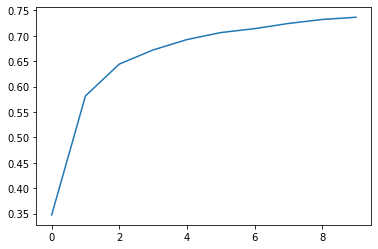

In [ ]:
plt.plot(accuracy)

In [ ]:
def show_adn_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.show()

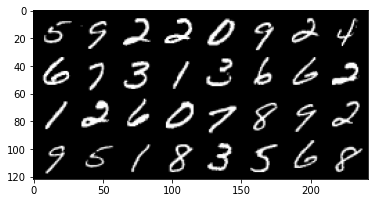

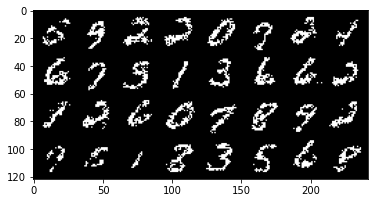

In [ ]:
show_adn_save("real",make_grid(v[:,0:784].view(32,1,28,28).data))
show_adn_save("generate",make_grid(v1[:,0:784].view(32,1,28,28).data))

### Pour bien visualiser la qualité de la reconstruction, on plot les images dans chaque epoch, et là nous allons voir que le modèle apprend bien les bons patterns qui caractérise chaque classe (chiffre de 0 à 9).   

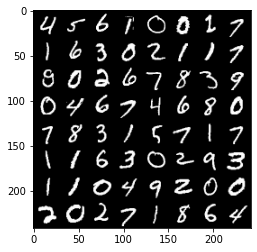

________________________
________________________


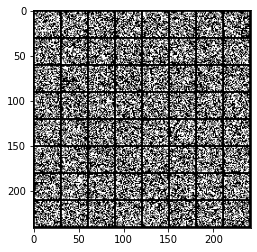

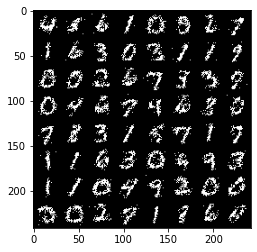

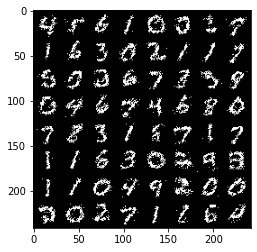

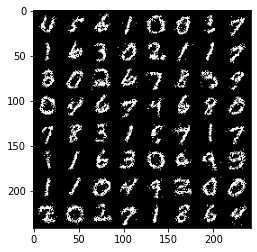

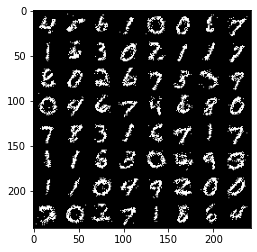

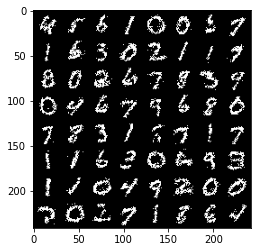

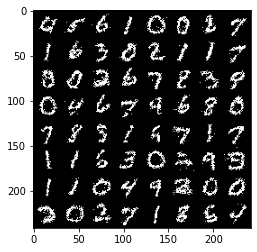

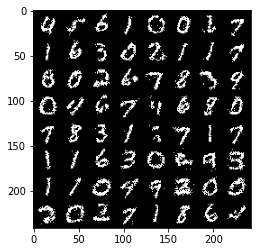

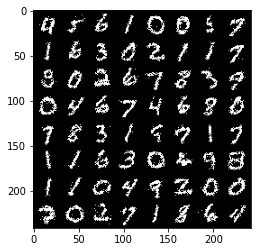

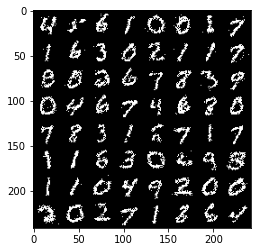

In [ ]:
show_adn_save("generate",make_grid(reconstructed[0][:,0:784].view(64,1,28,28).data))
print("________________________")
print("________________________")

for i in range(10):
  show_adn_save("real",make_grid(originals[i][:,0:784].view(64,1,28,28).data))


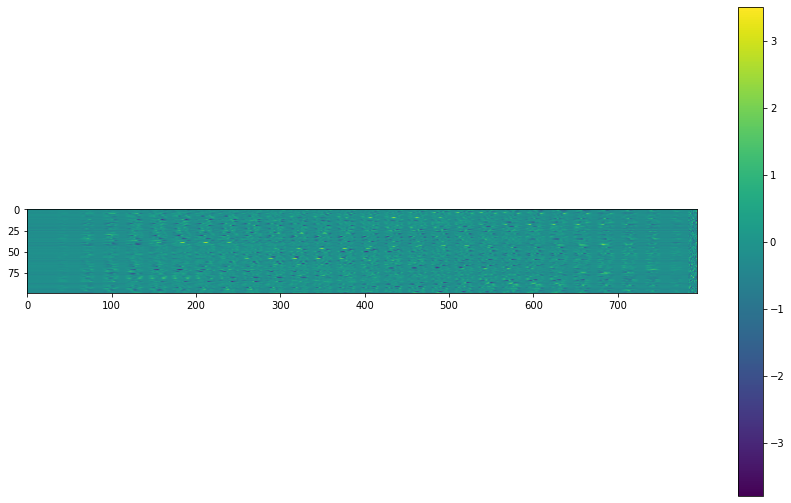

In [ ]:
plt.figure(figsize=(15, 9))
plt.imshow(rbm.W.detach())
plt.colorbar()

### La matrice des poids $W_i$ :

In [ ]:
rbm.W

Parameter containing:
tensor([[-0.1533, -0.1156, -0.1113,  ..., -0.2581,  0.0714,  1.3152],
        [-0.0898, -0.0943, -0.0899,  ...,  0.7879,  0.4259, -0.1731],
        [-0.2733, -0.2962, -0.2744,  ..., -0.1388, -0.0301, -0.0699],
        ...,
        [-0.2545, -0.2714, -0.2487,  ...,  0.3200, -0.8527, -0.3487],
        [-0.2278, -0.1969, -0.2403,  ...,  0.6552, -0.6658, -0.5764],
        [-0.3024, -0.2954, -0.2992,  ...,  1.3084,  1.2811, -0.9668]],
       requires_grad=True)

### Dans les plots ci-dessous, on essaie de visualiser la représentation des images du dernier batch dans l'espace des neurones cachés $h_i$ (v_to_h), et le code couleur (en gradient du rouge) représente les probabilités $P(h/v)$. Dans le deuxième plot, on visualise une simulation de $h$ sachant $v$ (avec une loi de Bernoulli).

### La dégradation de l'image reconstruite est due au probabilités intermédiaires ($les. p_i \in ]0,1[$)), ce qui laisse la possibilité de simuler des pixels abérants (dont la valeur simulée est différente de la valeur réelle).

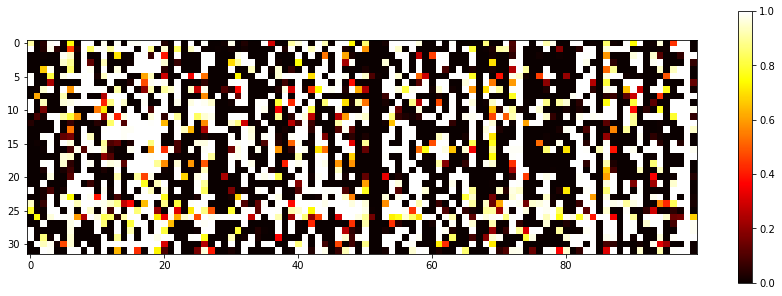

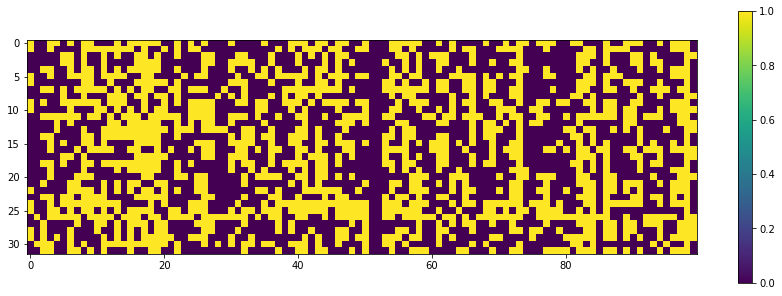

In [ ]:
plt.figure(figsize=(15,5))
plt.imshow(rbm.v_to_h(v1)[0].detach(), cmap = "hot")
plt.colorbar()
plt.show()

plt.figure(figsize=(15,5))
plt.imshow(rbm.v_to_h(v1)[1].detach())
plt.colorbar()
plt.show()


### Pour mieux visualiser le comportements des neurones cachés dans le cas où on simule le chiffre "1" comparé au chiffre "5" (deux chiffres qui s'écrivent différament). Nous allons représenter les probabilités pour simuler ses deux chiffres :

In [ ]:
Z_1  = torch.cat((Z_1, torch.nn.functional.one_hot(torch.tensor([1]*Z_1.shape[0]), num_classes=10)),1)
Z_5  = torch.cat((Z_5, torch.nn.functional.one_hot(torch.tensor([5]*Z_5.shape[0]), num_classes=10)),1)

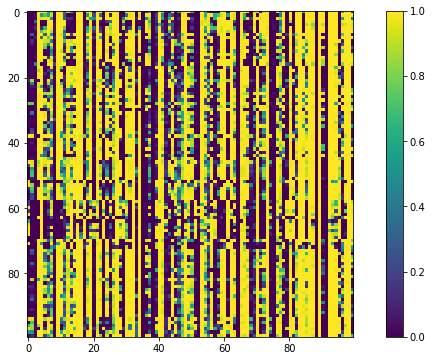

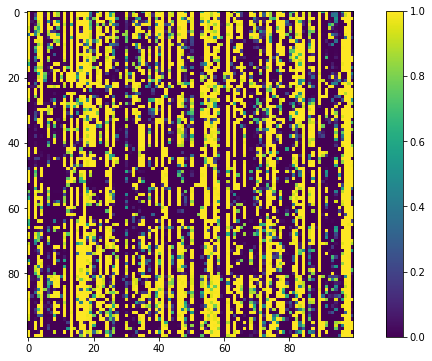

In [ ]:
plt.figure(figsize=(12,6))
plt.imshow(rbm.v_to_h(Z_1)[0].detach()[:100])
plt.colorbar()

plt.figure(figsize=(12,6))
plt.imshow(rbm.v_to_h(Z_5)[0].detach()[:100])
plt.colorbar()

### Nous pouvons facilement remarquer des patterns qui caractérisent la forme de chaque chiffre !